In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx

from tqdm import tqdm
import typing as tp
import pandas as pd
import math

import sys

import optax
import numpyro.distributions as D

from diffcv.mcmc.langevin import ULASampler
from diffcv.cv.nn import CVMLP, init_linear, normal_init
from diffcv.cv.training import CVTrainer, CVALSTrainer
from diffcv.cv.loss import DiffusionLoss, DiffLoss, VarLoss
from diffcv.logger import Logger, plot_log_results
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv.generator import ScalarGenerator, VectorGenerator
from diffcv.mcmc.estimator import Estimator

sns.set_style("darkgrid")

2024-08-08 15:11:58.960342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:11:58.960376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:11:58.960412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 15:11:59.688003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


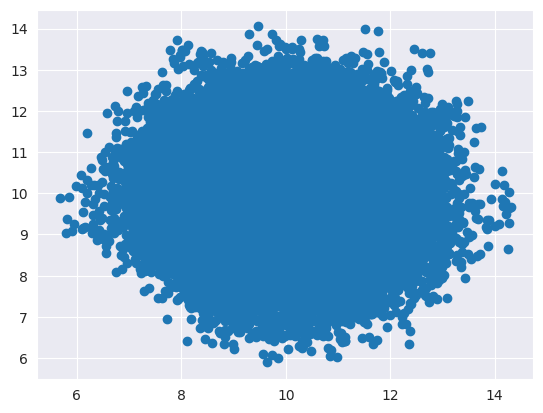

In [10]:
DIST_DIM = 10 # Dimension of a Gaussian
N_CHAINS = 100 # Number of parallel chains for MCMC estimates
MCMC_N_ESTIMATES = 1000 # Number of MCMC estimates to calculate CI
BATCH_SIZE = 256 # Batch size for CV training

rng = jax.random.PRNGKey(50)

dist = D.MultivariateNormal(loc=10 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float))
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
true_pi = (dist.mean ** 2).sum() + (dist.variance ** 2).sum()


sampler = ULASampler(grad_log_prob=grad_log_prob, dim=DIST_DIM, n_samples=1000, gamma=5e-2, burnin_steps=500, init_std=5.0)
rng, key = jax.random.split(rng)
samples = sampler(key, n_chains=N_CHAINS).reshape(-1, DIST_DIM)

plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

In [4]:
class ModelWithConstant(eqx.Module):
    model: eqx.Module
    c: jax.Array
    
    def __init__(self, model: eqx.Module, shape, key: jax.random.PRNGKey):
        self.model = model
        self.c = jax.random.normal(key, shape)
    
    @eqx.filter_jit
    def __call__(self, x):
        return self.model(x)

In [15]:
def train_model(
        rng: jax.random.PRNGKey, batch_size: int, 
        lr: float=1e-3, loss_fn: str="diffusion", optim: str="sgd",
        l2_alpha: float=0.0, n_steps: int=30_000, n_chains: int=1, *, logger: Logger
    ):
    
    rng, key = jax.random.split(rng)
    dataset, dataloader = get_data_from_sampler(batch_size, sampler, key, n_chains=n_chains)
    print(f"dataset length: {len(dataset)}")

    rng, key = jax.random.split(rng)
    model = CVMLP(in_size=DIST_DIM, depth=0, width_size=0, activation=jax.nn.elu, key=key)

    # rng, key = jax.random.split(rng)
    # model = init_linear(model, key, normal_init)

    scheduler = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    if optim == "sgd":
        optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler)
    elif optim == "adam":
        l2_alpha = 0
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
    else:
        raise NotImplementedError(f"unknown optimizer: {optim}")
    
    fn_mean = None
    if loss_fn == "diffusion":
        loss = DiffusionLoss(fn=fn, l2_alpha=l2_alpha)
        fn_mean = base_estimates.mean()
    elif loss_fn == "diff":
        loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)
    elif loss_fn == "var":
        rng, key = jax.random.split(rng)
        model = ModelWithConstant(model, (1,), key)
        loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)
    else:
        raise NotImplementedError(f"unknown loss function: {loss_fn}")

    trainer = CVTrainer(
        model, fn, dataloader, 
        optimizer, loss, logger, n_steps=n_steps, fn_mean=fn_mean
    )

    rng, key = jax.random.split(rng)
    model = trainer.train(key)
    
    return model

def train_als_model(
        rng: jax.random.PRNGKey, batch_size: int, lr: float=1e-3,
        n_steps: int=30_000, switch_steps:int=10_000, n_chains: int=1, *, logger: Logger
    ):
    
    rng, key = jax.random.split(rng)
    dataset, dataloader = get_data_from_sampler(batch_size, sampler, key, n_chains=n_chains)
    print(f"dataset length: {len(dataset)}")

    rng, key = jax.random.split(rng)
    model = CVMLP(in_size=DIST_DIM, depth=0, width_size=0, activation=jax.nn.elu, key=key)

    # rng, key = jax.random.split(rng)
    # model = init_linear(model, key, normal_init)

    scheduler_diffusion = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    optimizer_diffusion = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_diffusion)
    
    scheduler_stein = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    optimizer_stein = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_stein)
    
    loss_diffusion = DiffusionLoss(fn=fn, l2_alpha=0.0)
    loss_stein = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

    trainer = CVALSTrainer(
        model, fn, grad_log_prob, dataloader,
        optimizer_diffusion, optimizer_stein,
        loss_diffusion, loss_stein,
        logger=logger, switch_steps=switch_steps, n_steps=n_steps
    )

    rng, key = jax.random.split(rng)
    model = trainer.train(key)
    
    return model

In [6]:
rng, key = jax.random.split(rng)
base_estimates = Estimator(fn, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)
print("base:", Estimator.bias(true_pi, base_estimates), Estimator.std(base_estimates))

  0%|          | 0/1000 [00:00<?, ?it/s]

base: -0.2211914 1.2576327


dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion: -0.27105713 0.43427297


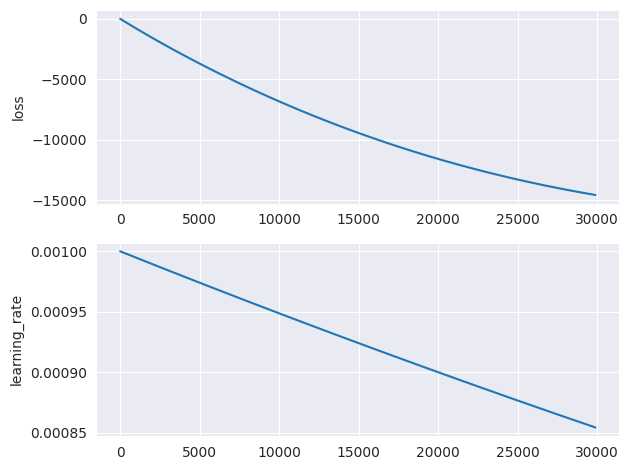

In [11]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key, batch_size=5000, lr=1e-3, loss_fn="diffusion", optim="adam", l2_alpha=0.0, n_steps=30_000, n_chains=5, logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

dataset length: 5000


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

diffusion als: -0.2567749 0.082018934


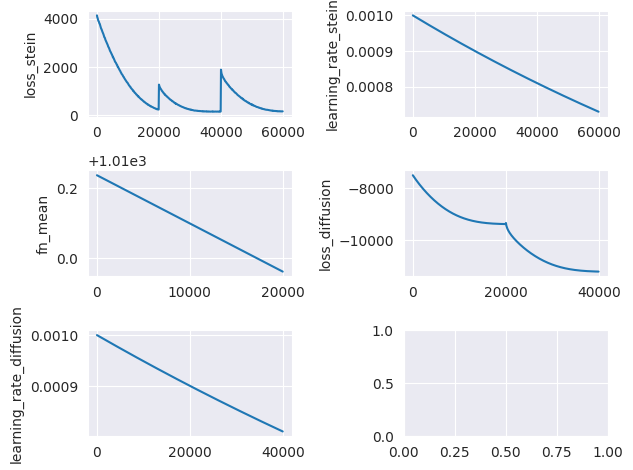

In [17]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_als_model(
    key, batch_size=5000, lr=1e-3, n_steps=100_000, switch_steps=20_000, n_chains=5, logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion als:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

dataset length: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

stein diff: -0.25769043 0.06441699


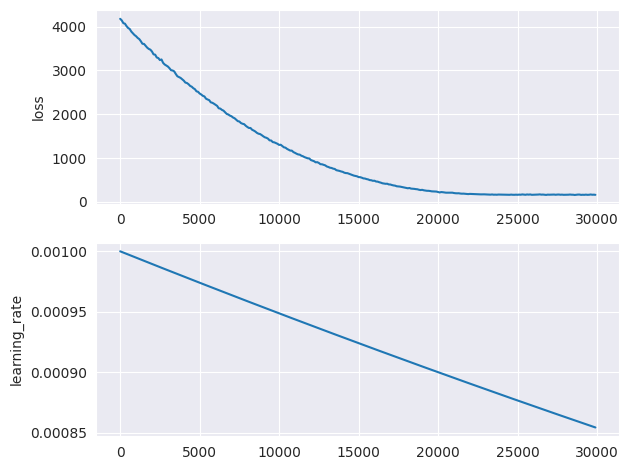

In [13]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key, batch_size=5000, loss_fn="diff", optim="adam", lr=1e-3, l2_alpha=0.0, n_steps=30_000, n_chains=5, logger=logger
)

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("stein diff:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

dataset length: 5000


  0%|          | 0/200000 [00:00<?, ?it/s]

learned constant: [1010.43744]


  0%|          | 0/1000 [00:00<?, ?it/s]

var min: -0.2562256 0.0650685


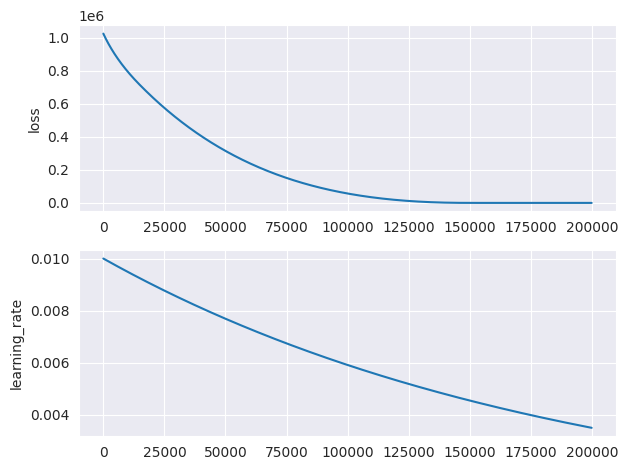

In [16]:
logger = Logger()

rng, key = jax.random.split(rng)
model = train_model(
    key, batch_size=5000, loss_fn="var", optim="adam", lr=1e-2, l2_alpha=0.0, n_steps=200_000, n_chains=5, logger=logger
)

print(f"learned constant: {model.c}")
model = model.model

plot_log_results(logger)

generator = ScalarGenerator(grad_log_prob, model)
fn_with_cv = lambda x: fn(x) + generator(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("var min:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

In [ ]:
jnp.trace(jax.hessian(cv_model)(jnp.ones((10), dtype=float)))

Array(0., dtype=float32)